In [1]:
%matplotlib widget

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import json
import requests
import matplotlib.pyplot as plt
from astropy.io import fits
from tqdm import tqdm
from pprint import pprint
import backoff
import numpy as np
from vasca.region import Region
from vasca.utils import nb_fig
from vasca.acms_api import acms_xmatch_query, get_acms_cat_info
from vasca.xmatch import xmatch_ampel, xmatch
from loguru import logger

In [4]:
logger.enable("vasca")

In [5]:
file = f"/Users/julianschliwinski/Library/Mobile Documents/com~apple~CloudDocs/PhD/ULTRASAT/Science/vasca/vasca/examples/vasca_pipeline/TDS_All/region_TDS_All.fits"
rg = Region()
rg.load_from_fits(file)

2023-05-17 15:51:53.990 | DEBUG    | vasca.tables:add_table:132 - Adding table 'region:tt_fields'
2023-05-17 15:51:53.993 | DEBUG    | vasca.tables:table_from_template:114 - Created new table from template 'region:tt_fields'.
2023-05-17 15:51:53.995 | DEBUG    | vasca.tables:load_from_fits:263 - Loading file with name '/Users/julianschliwinski/Library/Mobile Documents/com~apple~CloudDocs/PhD/ULTRASAT/Science/vasca/vasca/examples/vasca_pipeline/TDS_All/region_TDS_All.fits'
2023-05-17 15:51:54.015 | DEBUG    | vasca.tables:load_from_fits:274 - Loading table 'tt_fields'
2023-05-17 15:51:54.016 | WARNING  | vasca.tables:load_from_fits:277 - Table 'tt_fields' already exists, overwriting.
2023-05-17 15:51:54.049 | DEBUG    | vasca.tables:load_from_fits:274 - Loading table 'tt_visits'
2023-05-17 15:51:54.068 | DEBUG    | vasca.tables:load_from_fits:274 - Loading table 'tt_detections'
2023-05-17 15:51:54.226 | DEBUG    | vasca.tables:load_from_fits:274 - Loading table 'tt_coadd_detections'
202

In [6]:
vasca_cat = rg.tt_sources["ra","dec","rg_src_id"][rg.tt_sources["sel"]]

In [7]:
api = "ampel"
catalog = "PS1"
radius = 5.0
coords = vasca_cat["ra", "dec"]
ids = vasca_cat["rg_src_id"]

tt_matched = xmatch(
    api=api,
    catalog=catalog,
    radius=radius,
    coords=coords,
    ids=ids,
    dropna=True,
    hide_progress=False,
)

2023-05-17 15:51:54.824 | DEBUG    | vasca.xmatch:xmatch:68 - Running x-matching via ampel API
2023-05-17 15:51:55.133 | DEBUG    | vasca.acms_api:get_acms_cat_info:73 - Fetching available catalogs from Ampel Catalog Matching Service.
X-match PS1: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1588/1588 [03:58<00:00,  6.66it/s]


In [10]:
tt_matched[:10]

vasca_id,vasca_ra,vasca_dec,vasca_dist,RA,Dec,ErrRA,ErrDec,MeanEpoch,posMeanChi2,gPSFMag,gPSFMagErr,gpsfLikelihood,gMeanPSFMagStd,gMeanPSFMagNpt,gMeanPSFMagMin,gMeanPSFMagMax,rPSFMag,rPSFMagErr,rpsfLikelihood,rMeanPSFMagStd,rMeanPSFMagNpt,rMeanPSFMagMin,rMeanPSFMagMax,iPSFMag,iPSFMagErr,ipsfLikelihood,iMeanPSFMagStd,iMeanPSFMagNpt,iMeanPSFMagMin,iMeanPSFMagMax,zPSFMag,zPSFMagErr,zpsfLikelihood,zMeanPSFMagStd,zMeanPSFMagNpt,zMeanPSFMagMin,zMeanPSFMagMax,yPSFMag,yPSFMagErr,ypsfLikelihood,yMeanPSFMagStd,yMeanPSFMagNpt,yMeanPSFMagMin,yMeanPSFMagMax
,deg,deg,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
int32,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
70,334.7211626255977,0.3913839571562643,2.1018477415065524,5.841976883542938,0.006834675491422306,0.001,0.001,56262.99362269,2.0925,15.3267,0.00084,-0.362599,0.010207,7.0,15.3424,15.3698,14.8614,0.000434,-0.552762,0.004607,10.0,14.907,14.9211,14.7373,0.000277,0.824251,0.010297,29.0,14.7247,14.7588,14.6682,0.00066,0.704944,0.006165,8.0,14.677,14.6955,14.6139,0.001065,0.781377,0.012522,8.0,14.606,14.6475
156,334.60402550008,0.4073711880956681,1.076733882550584,5.839947155332793,0.007110029455258293,0.001,0.001,56102.66738426,1.9545,18.6061,0.003659,0.000497703,0.055692,12.0,18.5664,18.7318,18.357,0.002709,0.00497429,0.033299,11.0,18.4,18.5225,18.7115,0.003791,2.06845e-05,0.022325,14.0,18.6148,18.6904,18.3687,0.006574,0.0448003,0.056408,9.0,18.1799,18.3387,18.1323,0.011355,0.00179104,0.077159,7.0,17.9578,18.1791
358,334.37172672267315,0.14254561060438567,0.5108497450233881,5.835889831355781,0.002488870405671674,0.001,0.001,55912.75212963,1.5262,18.6098,0.004547,0.648154,0.028697,10.0,18.5719,18.6429,18.8704,0.004799,0.392744,0.035429,14.0,18.7696,18.8985,19.1137,0.005097,-0.993053,0.059113,24.0,19.0548,19.2713,19.3402,0.019209,0.544678,0.150556,8.0,18.933,19.3692,19.5965,0.050843,-0.286054,0.260879,5.0,19.181,19.6978
368,334.3605970044044,0.2280129466197396,1.3278909076543137,5.835687061097679,0.00397801499407052,0.001,0.001,56127.59528935,1.4321,15.4056,0.000683,-0.459419,0.0092,10.0,15.4321,15.4609,15.0042,0.000463,-0.854677,0.008571,11.0,14.9895,15.0174,14.9671,0.000385,0.00378689,0.006837,16.0,14.8362,14.8609,14.7673,0.000697,-0.937227,0.032618,11.0,14.751,14.8693,14.716,0.000988,-0.483156,0.016903,8.0,14.7185,14.7609
398,334.33170034997175,-0.533246042848342,0.7130864873009493,5.835191453389026,-0.0093092991234758,0.001,0.001,55983.89731481,1.0713,20.2651,0.012503,0.750021,0.137662,10.0,20.0754,20.4714,20.1236,0.012362,-0.415089,0.129183,11.0,20.0035,20.3773,20.1446,0.011519,0.555057,0.182425,18.0,20.1188,20.6758,20.0307,0.024604,-0.0164843,0.126024,10.0,19.7795,20.1257,20.0516,0.084226,-0.0290496,0.080584,5.0,19.6724,19.8868
525,334.1672365373477,0.272298214043041,0.11327714465551093,5.8323184796482215,0.004751953500132298,0.001,0.001,55992.14416667,1.0635,19.3144,0.006629,0.699848,0.024098,9.0,19.2196,19.2909,18.8492,0.006206,-0.275641,0.037136,8.0,18.903,19.0072,18.9929,0.004935,0.0391769,0.152268,19.0,18.9371,19.3061,18.8802,0.009708,0.000240116,0.053195,11.0,18.8064,18.9764,18.7525,0.017675,0.0536069,0.099578,12.0,18.6083,18.9079
611,334.09394119092696,-0.29467736418453433,0.5440424888959358,5.831040584651029,-0.00514538527105101,0.001,0.001,55847.50174769,6.0879,14.3005,0.000407,0.757386,0.007226,10.0,14.2836,14.3021,13.8559,0.000288,0.000133243,0.008258,2.0,13.7285,13.7373,13.8803,0.00026,4.8279e-11,0.002814,2.0,13.4971,13.5003,13.7293,0.000606,2.58755e-22,0.010216,4.0,13.3664,13.3904,13.3855,0.000626,0.000616585,0.01068,5.0,13.3026,13.3304
626,334.0843579649877,-0.27553777714282396,0.45128600702353194,5.830872879104797,-0.004811056108191358,0.001,0.001,56140.71903935,0.8805,1

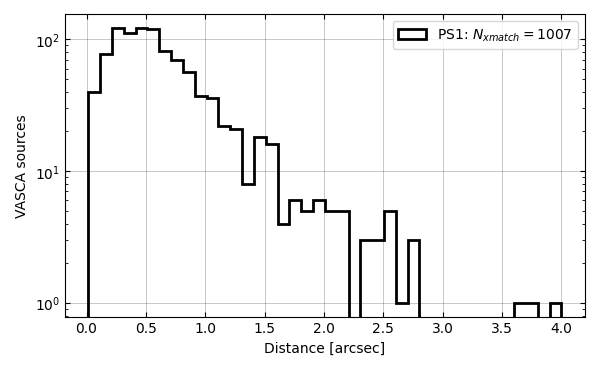

In [8]:
fig, ax = nb_fig(num="dist_hist", gr_size=6, layout="tight")
ax.hist(
    tt_matched["vasca_dist"],
    histtype="step",
    bins="auto",
    lw=2,
    color="k",
    label=f"{catalog}: $N_{{xmatch}} = {len(tt_matched)}$"
)
ax.set_xlabel("Distance [arcsec]")
ax.set_ylabel("VASCA sources")

ax.set_yscale("log")

ax.grid(True, linewidth=0.5, color="k", alpha=0.3, zorder=0)
ax.tick_params(
    axis="y", direction="in", left=True, right=True, which="both"
)
ax.tick_params(
    axis="x", direction="in", top=True, bottom=True, which="both"
)

_ = ax.legend()

In [9]:
get_acms_cat_info()["PS1"]

2023-05-17 15:55:54.576 | DEBUG    | vasca.acms_api:get_acms_cat_info:73 - Fetching available catalogs from Ampel Catalog Matching Service.


{'name': 'PS1',
 'use': 'catsHTM',
 'description': 'PS1 -- Pan-STARRS (~2.6x10^9 sources; A cleaned version of the PS1 stack catalog; some missing tiles below declination of zero [being corrected])',
 'reference': 'https://doi.org/10.1088/1538-3873/aac410',
 'contact': 'Eran Ofek <eran.ofek@weizmann.ac.il>',
 'columns': [{'name': 'RA', 'unit': 'rad'},
  {'name': 'Dec', 'unit': 'rad'},
  {'name': 'ErrRA', 'unit': 'arcsec'},
  {'name': 'ErrDec', 'unit': 'arcsec'},
  {'name': 'MeanEpoch', 'unit': 'MJD'},
  {'name': 'posMeanChi2', 'unit': None},
  {'name': 'gPSFMag', 'unit': 'mag'},
  {'name': 'gPSFMagErr', 'unit': 'mag'},
  {'name': 'gpsfLikelihood', 'unit': None},
  {'name': 'gMeanPSFMagStd', 'unit': 'mag'},
  {'name': 'gMeanPSFMagNpt', 'unit': None},
  {'name': 'gMeanPSFMagMin', 'unit': 'mag'},
  {'name': 'gMeanPSFMagMax', 'unit': 'mag'},
  {'name': 'rPSFMag', 'unit': 'mag'},
  {'name': 'rPSFMagErr', 'unit': 'mag'},
  {'name': 'rpsfLikelihood', 'unit': None},
  {'name': 'rMeanPSFMagStd'